**Relevant huggingface gpt2 code**

- https://github.com/huggingface/transformers/blob/main/src/transformers/models/gpt2/modeling_gpt2.py
- https://github.com/huggingface/transformers/blob/main/src/transformers/generation/utils.py
- https://github.com/huggingface/transformers/issues/6535
- bos/eos discussion: https://github.com/huggingface/transformers/issues/3311

**Some options for our main model**

- different gpt2 sizes
- gpt2 self-att vs gpt-2 cross-att (image captioning)
- which gpt2 layers to finetune?
- first pretrain on labels, then captions? or at the same time with different prompt/`<bos>` token?
- make b2t output a bunch of 768 dimensional vectors that gpt2 self-att attends to

In [1]:
#!pip install -U yt-dlp==2023.1.6 matplotlib==3.6.0 datasets[audio] rich

# install newest transformers build to be able to pass `inputs_embeds` through generate()
!pip install --upgrade git+https://github.com/huggingface/transformers.git

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-qcxqfnij
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-qcxqfnij
  Resolved https://github.com/huggingface/transformers.git to commit b90fbc7e0ba41dfd6b343e7e2274443f19087f36
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.27.0.dev0-py3-none-any.whl size=6708062 sha256=5d26f286834077714189d98378e87b1fbecb1fae2884d5934f805abbb2629a94
  Stored in directory: /tmp/pip-ephem-wheel-cache-ghwhde7p/wheels/f7/92/8c/752ff3bfcd3439805d8bbf641614da38ef3226e127ebea86ee
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.21.3
    Uninstalling transformers-4.21.3:
      Successfully uninstalled transformers-4.21.3


In [2]:
!pip install torch==1.13

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.2/890.2 MB 2.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 44.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 69.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 6.4 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu116
    Uninstalling torch-1.12.1+cu116:
      Successfully uninstalled torch-1.12.1+cu116
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.13.1+cu116 requires torch==1.12.1, but you have torch 1.13.0 which is incompatible.
torchaudio 0.12.1+cu116 requires torch==1.12.1, but you have torch 1.13.0 which is incompatible.


In [3]:
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 14.5 MB/s eta 0:00:00


In [4]:
from musiccaps import load_musiccaps

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split, Subset

from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import VisionEncoderDecoderModel, ViTFeatureExtractor, AutoTokenizer

from rich import print as printr
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt

import itertools
import math
import json
import random
from collections import defaultdict
from pathlib import Path
import evaluate
import itertools

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
f = open('logs.txt','a')

# Load musiccaps

In [5]:
def filter_muscaps_with_embeddings(ds, embeddings):
    """Some clips weren't downloaded so we couldn't embed them, get rid of that"""
    exclude_ids = set()
    for i in range(len(ds)):
        if ds[i]["ytid"] not in embeddings.keys():
            exclude_ids.add(i)
    ds = ds.select((i for i in range(len(ds)) if i not in set(exclude_ids)))
    assert len(ds) == len(embeddings)
    return ds


In [6]:
ls /datasets/beat2tweet/

embeddings.npy     embeddings_75.npy  tag_scores_51.npy  tags_26.json
embeddings_00.npy  embeddings_76.npy  tag_scores_52.npy  tags_27.json
embeddings_01.npy  embeddings_77.npy  tag_scores_53.npy  tags_28.json
embeddings_02.npy  embeddings_78.npy  tag_scores_54.npy  tags_29.json
embeddings_03.npy  embeddings_79.npy  tag_scores_55.npy  tags_30.json
embeddings_04.npy  embeddings_80.npy  tag_scores_56.npy  tags_31.json
embeddings_05.npy  embeddings_81.npy  tag_scores_57.npy  tags_32.json
embeddings_06.npy  embeddings_82.npy  tag_scores_58.npy  tags_33.json
embeddings_07.npy  embeddings_83.npy  tag_scores_59.npy  tags_34.json
embeddings_08.npy  embeddings_84.npy  tag_scores_60.npy  tags_36.json
embeddings_09.npy  embeddings_85.npy  tag_scores_61.npy  tags_37.json
embeddings_10.npy  embeddings_86.npy  tag_scores_62.npy  tags_38.json
embeddings_11.npy  embeddings_87.npy  tag_scores_63.npy  tags_39.json
embeddings_12.npy  embeddings_88.npy  tag_scores_64.npy  tags_40.json
embeddings_13.npy  e

In [7]:
ds = load_musiccaps(
    "./music_data",
    sampling_rate=16000,
    limit=None,
    num_proc=8,
    writer_batch_size=1000,
    return_without_audio=True,
)
embeddings = np.load("embeddings.npy", allow_pickle=True).item()

Using custom data configuration google--MusicCaps-bedc2a0fd7888f2f


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

/usr/local/lib/python3.9/dist-packages/datasets/download/streaming_download_manager.py:695: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  return pd.read_csv(xopen(filepath_or_buffer, "rb", use_auth_token=use_auth_token), **kwargs)


Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/google___csv/google--MusicCaps-bedc2a0fd7888f2f/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a. Subsequent calls will reuse this data.


In [8]:
# get a list of music-related words to use for evaluation
aspects = []
for x in ds:
    aspect_str = x["aspect_list"]
    for t in "[]\"'":
        aspect_str = aspect_str.replace(t, "")
    aspects.extend(aspect_str.split(", "))

from collections import Counter

# only pick aspects that show up somewhat frequently
aspects = {s for s, count in Counter(aspects).most_common() if count >= 25}
len(aspects)

378

In [9]:
class CaptionEmbedding(Dataset):
    """Returns a torch Dataset of paired captions and embeddings"""

    def __init__(self, muscaps_ds, embeddings, chat_aug=False, aug_captions=None):
        ds = filter_muscaps_with_embeddings(muscaps_ds, embeddings)
        self.captions = ds.sort("ytid")["caption"]
        sorted_embs = [value for _, value in sorted(embeddings.items())]
        self.embeddings = torch.from_numpy(np.stack(sorted_embs)).to(device)
        self.chat_aug = chat_aug
        if chat_aug:
            self.aug_captions = [value for _, value in sorted(aug_captions.items())]

    def __len__(self):
        return len(self.captions)

    def __getitem__(self, idx):
        emb = self.embeddings[idx]
        assert len(emb) == 512
        emb = (emb[:256] + emb[256:]) / 2
        caption = self.captions[idx]
        if self.chat_aug:
            if torch.rand(1).item() < .5: caption = self.aug_captions[idx]

        return caption, emb

In [11]:
use_chat_aug = True

with open('chataug.json', 'r') as fp:
    chataug_captions = json.load(fp)
    
with open('musiccaps_split.json', 'r') as fp:
    musiccaps_split = json.load(fp)

train_ytids, valid_ytids, test_ytids = musiccaps_split['train'], musiccaps_split['valid'], musiccaps_split['test']

train_ds = ds.filter(lambda x: x['ytid'] in train_ytids)
valid_ds = ds.filter(lambda x: x['ytid'] in valid_ytids)
test_ds = ds.filter(lambda x: x['ytid'] in test_ytids)

train_embeddings = {ytid: e for ytid, e in embeddings.items() if ytid in train_ytids}
valid_embeddings = {ytid: e for ytid, e in embeddings.items() if ytid in valid_ytids}
test_embeddings = {ytid: e for ytid, e in embeddings.items() if ytid in test_ytids}

training_data = CaptionEmbedding(muscaps_ds=train_ds, embeddings=train_embeddings, 
                                 chat_aug=use_chat_aug, aug_captions=chataug_captions)
valid_data = CaptionEmbedding(muscaps_ds=valid_ds, embeddings=valid_embeddings)
test_data = CaptionEmbedding(muscaps_ds=test_ds, embeddings=test_embeddings) 
    

Loading cached processed dataset at /root/.cache/huggingface/datasets/google___csv/google--MusicCaps-bedc2a0fd7888f2f/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-65e36bf881a776b6.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/google___csv/google--MusicCaps-bedc2a0fd7888f2f/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-b43b658bbefe199e.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/google___csv/google--MusicCaps-bedc2a0fd7888f2f/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-f4182c0212b9d53a.arrow
Parameter 'indices'=<generator object filter_muscaps_with_embeddings.<locals>.<genexpr> at 0x7f62b1a995f0> of the transform datasets.arrow_dataset.Dataset.select couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to

N = len(ds['ytid'])
shuffled_indices = torch.randperm(N)
train_N, valid_N = round(N*0.8), round(N*0.1)
train_indices, valid_indices, test_indices = shuffled_indices[:train_N], shuffled_indices[train_N:train_N+valid_N], shuffled_indices[train_N+valid_N:]
train_ids, valid_ids, test_ids = ds[train_indices]['ytid'], ds[valid_indices]['ytid'], ds[test_indices]['ytid']
split_json = {'train':train_ids, 'valid':valid_ids, 'test':test_ids}
with open('musiccaps_split.json', 'w') as fp:
    json.dump(split_json, fp)

# Training

### Tokenization

target should be:

`"<bos> <pad> caption <eos> <mask...>"` (first element is dropped in transformer.forward)

input should be:

`"<bos> <music-emb> caption <eos> <pad...>"` (last element is dropped in transformer.forward)

where

- `<bos>` = `<eos>` (for gpt2, see https://github.com/huggingface/transformers/issues/2026)
- `<mask>` is -100 (masked in cross-entropy, see https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)
- `<pad>` is arbitrary (but needs to be valid embedding index)
- `<music-emb>` is the encoded music

to use a `<bos>` token, prepend it in `tokenize()`, set `music_emb_ind = 1`, and update the caption slicing in `eval`

In [12]:
class ResidualLinear(nn.Module):
    
    def __init__(self, dim):
        super().__init__()
        self.fc = nn.Linear(dim, dim)
        
    def forward(self, x):
        return x + self.fc(torch.nn.functional.relu(x))
    
def B2T():
    return nn.Sequential(
        nn.Linear(256, 768),
        ResidualLinear(768),
        nn.Dropout(0.6),
        ResidualLinear(768),
        nn.Dropout(0.4),
        ResidualLinear(768),
    )

In [13]:
def tokenize(captions_batch):
    input_ids = tokenizer(captions_batch)["input_ids"]

    # wrap in eos and add placeholder for music embedding/mask
    input_ids = [torch.tensor([placeholder_id] + x + [eos_id]) for x in input_ids]
    # pad with -100, this index is masked in the cross-entropy loss
    input_ids_target = torch.nn.utils.rnn.pad_sequence(
        input_ids, batch_first=True, padding_value=mask_id
    ).to(device)

    # index -100 isn't valid as model input however, since the token embedding lookup fails,
    # so we need a second version as model input, with -100 replaced with another token (shouldn't matter which)
    input_ids = input_ids_target.clone()
    input_ids[input_ids == mask_id] = eos_id

    return input_ids, input_ids_target


def transform_input_ids(music_embedding, input_ids, input_ids_target):
    music_emb_ind = 0  # 1 if using <bos>, otherwise 0
    assert (input_ids[:, music_emb_ind] == placeholder_id).all()
    assert (input_ids_target[:, music_emb_ind] == placeholder_id).all()

    input_ids_target[:, music_emb_ind] = eos_id  # mask_id
    input_ids[:, music_emb_ind] = eos_id  # temp placeholder to make the embedding lookup work
    inputs_embeds = model.transformer.wte(input_ids)

    inputs_embeds[:, music_emb_ind] = b2t(music_embedding)  # insert music embedding

    return inputs_embeds, input_ids_target


def strip_eos(pred):
    """ 
    remove eos tokens from predicted captions 
    discards everything after the first <eos> that isn't the very first token
    (the hf can only skip eos but not stop at eos) 
    """
    pred = [p.removeprefix("<|endoftext|>") for p in pred]
    pred = [p[: p.find("<|endoftext|>")] if "<|endoftext|>" in p else p for p in pred]
    return pred


def eval(caption_batch, embedding_batch, rm_eos=False, **kwargs):
    model.eval()
    input_ids, input_ids_target = tokenize(caption_batch)
    inputs_embeds, _ = transform_input_ids(embedding_batch, input_ids, input_ids_target)

    # only include <bos> (optional) and music_embedding, don't include true caption
    inputs_embeds = inputs_embeds[:, :1]
    output_ids = model.generate(inputs_embeds=inputs_embeds, **kwargs)
    pred = tokenizer.batch_decode(output_ids, skip_special_tokens=False)
    pred = [p.replace("\n", "").strip() for p in pred]
    return strip_eos(pred) if rm_eos else pred

In [14]:
def update_step(inputs_embeds, input_ids_target, apply_grad):
    model.train()
    loss = model.forward(inputs_embeds=inputs_embeds, labels=input_ids_target).loss
    loss.backward()
    
    if apply_grad:
        opt.step()
        opt.zero_grad()
    
    return loss.item()

def eval_step(string_info=""):
    
    caption_batch, embedding_batch = next(iter(eval_train_dataloader))
    pred = eval(caption_batch, embedding_batch, **generation_params)
    printr('[green bold]TRAIN TRUE: ' + caption_batch[0])
    printr('[yellow]TRAIN PRED: ' + pred[0])
    wlog('TRAIN TRUE: ' + caption_batch[0])
    wlog('TRAIN PRED: ' + pred[0])
    caption_batch, embedding_batch = next(iter(eval_valid_dataloader))
    pred = eval(caption_batch, embedding_batch, **generation_params)
    printr('[green bold]TEST TRUE: ' + caption_batch[0])
    printr('[yellow]TEST PRED: ' + pred[0])
    wlog('TEST TRUE: ' + caption_batch[0])
    wlog('TEST PRED: ' + pred[0])
    print()
    
def metrics_step(n=100, shuffles=10):
    
    print(f"Computing metrics for n={n}")
    wlog(f"Computing metrics for n={n}")
    
    shuffled_meteor_valid, shuffled_bleu_valid = 0., 0.
    train_captions, train_preds = [], []
    valid_captions, valid_preds = [], []

    for i in tqdm(range(n)):

        caption_batch, embedding_batch = next(iter(eval_train_dataloader))
        pred = eval(caption_batch, embedding_batch, **generation_params)
        train_captions.append(caption_batch[0])
        train_preds.append(pred[0])

        caption_batch, embedding_batch = next(iter(eval_valid_dataloader))
        pred = eval(caption_batch, embedding_batch, **generation_params)
        valid_captions.append(caption_batch[0])
        valid_preds.append(pred[0])

    meteor_train = meteor.compute(predictions=train_preds, references=train_captions)['meteor']
    bleu_train = google_bleu.compute(predictions=train_preds, references=train_captions)['google_bleu']

    meteor_valid = meteor.compute(predictions=valid_preds, references=valid_captions)['meteor']
    bleu_valid = google_bleu.compute(predictions=valid_preds, references=valid_captions)['google_bleu']
    
    for j in range(shuffles):
        shuffled_captions = sorted(valid_captions, key=lambda k: random.random())
        shuffled_meteor_valid += (1./(shuffles))*meteor.compute(predictions=valid_preds, references=shuffled_captions)['meteor']
        shuffled_bleu_valid += (1./(shuffles))*google_bleu.compute(predictions=valid_preds, references=shuffled_captions)['google_bleu']

    spec_meteor = meteor_valid - shuffled_meteor_valid
    spec_bleu = bleu_valid - shuffled_bleu_valid
        
    print(f"Train meteor: {meteor_train:.4f}, Train bleu: {bleu_train:.4f}")
    wlog(f"Train meteor: {meteor_train:.4f}, Train bleu: {bleu_train:.4f}")
    print(f"Valid meteor: {meteor_valid:.4f}, Valid bleu: {bleu_valid:.4f}")
    wlog(f"Valid meteor: {meteor_valid:.4f}, Valid bleu: {bleu_valid:.4f}")
    print(f"Valid spec-meteor: {spec_meteor:.4f}, Valid spec-bleu: {spec_bleu:.4f}")
    wlog(f"Valid spec-meteor: {spec_meteor:.4f}, Valid spec-bleu: {spec_bleu:.4f}")
    
    return {'meteor_train': meteor_train,
            'meteor_valid': meteor_valid,
            'bleu_train': bleu_train,
            'bleu_valid': bleu_valid,
            'spec_meteor': spec_meteor,
            'spec_bleu': spec_bleu} 

m_styles = {"meteor_train": ("tab:orange", "solid"),
    "meteor_valid": ("tab:orange", "dashed"),
    "bleu_train": ("tab:blue", "solid"),
    "bleu_valid": ("tab:blue", "dashed"),
    "spec_bleu": ("tab:blue", "dashdot"),
    "spec_meteor": ("tab:orange", "dashdot")
}
    

In [15]:
model_name = 'gpt2' # gpt2, gpt2-medium, gpt2-large, gpt2-xl
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
model.config.is_decoder = True # not sure if necessary

mask_id = -100 # don't change, this is fixed in torch cross-entropy loss!
eos_id = tokenizer.eos_token_id
placeholder_id = -200
b2t = B2T().cuda()
b2t_lr = 1e-4
gpt2_finetune_lr = 1e-4

opt = torch.optim.AdamW([
    # b2t needs to be the first parameter group
    {'params': b2t.parameters(), 'lr': b2t_lr},
    
    # disable AdamW weight decay for gpt2 layer finetuning
    {'params': model.transformer.h[1].parameters(), 'lr': gpt2_finetune_lr, 'weight_decay': 0},
    {'params': model.transformer.h[2].parameters(), 'lr': gpt2_finetune_lr, 'weight_decay': 0},
])

batch_size = 32
num_epochs = 500
epoch = 0
gradient_acc_fact = 1
gpt2_finetune_start_epoch = 0

generation_params = dict(
    max_new_tokens=64,
    num_beams=4,
    do_sample=True,
    temperature=1.0,
    bos_token_id=eos_id,
    eos_token_id=eos_id,
    pad_token_id=mask_id,
    early_stopping=True,
    rm_eos=True,
)

losses = []

train_dataloader = DataLoader(training_data, batch_size, shuffle=True)
eval_train_dataloader = DataLoader(training_data, 1, shuffle=True)
eval_valid_dataloader = DataLoader(valid_data, 1, shuffle=True)

meteor = evaluate.load('meteor')
google_bleu = evaluate.load("google_bleu")
metrics = {'step': [], 'bleu_train': [], 'bleu_valid': [], 'meteor_train': [], 'meteor_valid': [],
          'spec_bleu': [], 'spec_meteor':[]}

checkpoint_dir = Path('checkpoints')
checkpoint_dir.mkdir(exist_ok=True)

load_pretrain = False
pretrain_model =  "checkpoints/chkp_no_0.0001_0_0.0001_e245.pt"
if load_pretrain:
    data_dict = torch.load(pretrain_model)
    model.load_state_dict(data_dict['model'])
    b2t.load_state_dict(data_dict['b2t'])
    
keep_training = False
if keep_training:
    with open(f'outputs/train_metrics_{string_info}.npy', 'rb') as f:
        train_metrics = np.load(f, allow_pickle=True).item()
    
    losses = list(train_metrics['loss'])
    metrics = {k: list(v) for k,v in train_metrics.items()}

model_name_info = "small" if model_name == 'gpt2' else model_name
pretraining_info = "yes" if load_pretrain else "no"
chat_aug_info = "_chataug" if use_chat_aug else ""
string_info = f"{pretraining_info}_{gpt2_finetune_lr}_{gpt2_finetune_start_epoch}_{b2t_lr}{chat_aug_info}"

def wlog(s):
    f = open(f"outputs/logs_{string_info}.txt",'a')
    f.write(s+"\n")
    f.close()

string_info

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


'no_0.0001_0_0.0001_chataug'

  0%|          | 0/500 [00:00<?, ?it/s]

Started finetuning b2t


  0%|          | 0/138 [00:00<?, ?it/s]

TRAIN TRUE: The low quality recording features a wide filtered, reverberant laser synth, punchy kick layered with 
energetic crash cymbal and synth pad chord. It sounds suspenseful, intense and weird.

TRAIN PRED: ."I'm not even going to do that. I'm not even going to do that. I'm not even going to do that. I'm not 
even going to do that. I'm not even going to do that. I'm not even going to do that. I'm not even going to

TEST TRUE: The low quality recording features an ambient song that consists of mellow dark synth pad chords 
playing. It sounds calming, relaxing and hypnotic.

TEST PRED: .In the U.S., there is a tendency to believe that the world is a better place, and that it is a better 
place to live.This is not the case. The U.S. is a very different place.This is the U.K.The

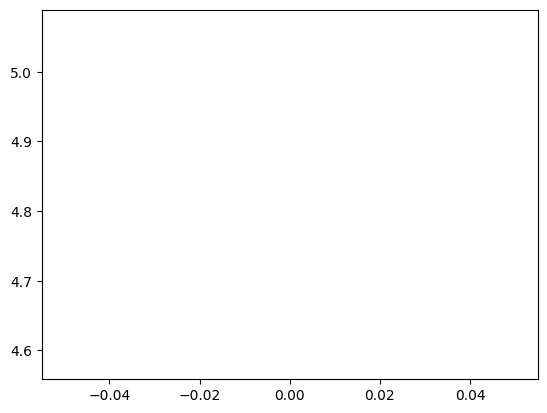

Computing metrics for n=100


  0%|          | 0/100 [00:00<?, ?it/s]

Train meteor: 0.0736, Train bleu: 0.0290
Valid meteor: 0.0759, Valid bleu: 0.0298
Valid spec-meteor: 0.0010, Valid spec-bleu: -0.0012


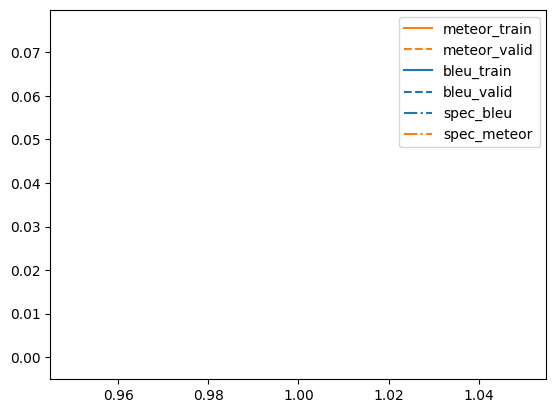

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

TRAIN TRUE: A male vocalist is accompanied by an electric guitar and Hammond organ in a jazz trio playing a swing 
blues song. The drummer provides a steady ride pattern on the cymbals while the entire band hits on beat one with 
drum breaks, a characteristic of this music genre.

TRAIN PRED: The low quality recording features a live performance of a pop song that consists of harmonizing female
vocals singing over groovy bass guitar melody, groovy bass guitar, punchy snare and punchy kick hits. It sounds 
passionate and passionate.

TEST TRUE: This is a latin folk piece performed at a home setting. There is a male vocalist singing off-key in a 
shout-like manner. An accordion and a ukulele are providing the melodic background for the piece. A pair of maracas
is being played for the rhythmic background. The piece has a joyful atmosphere. The instrumentals can be used for 
sampling to put them in a beat.

TEST PRED: The low quality recording features a live performance of a folk song that consists of a female vocal 
singing over sustained strings melody, groovy bass, groovy piano melody, punchy kick and snare hits, warm acoustic 
drums, warm warm electric guitar melody and warm warm acoustic drums. It sounds passionate, emotional and 
passionate.

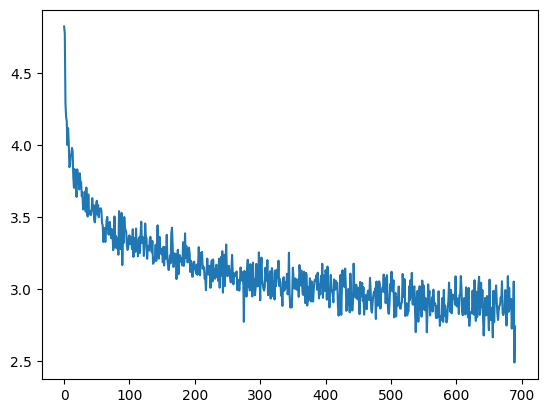

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

TRAIN TRUE: This song features a rubber instrument being played. The strumming is fast. The melody is played on one
fretted string and other open strings. The melody is played on the lower octave and is later repeated on the higher
octave. This song can be played at a folk party.

TRAIN PRED: The song is an instrumental. The song is medium tempo with a groovy bass line, groovy piano 
accompaniment, steady drumming rhythm and keyboard harmony. The song is a groovy jazz song. The audio quality is 
poor.

TEST TRUE: This is a pop music piece. There is a medium-to-high pitch male vocal singing melodically in the lead. 
The melody is being played by the strings and the piano. There is a loud but simple electronic drum beat in the 
rhythmic background. The piece is in major key, so there is an optimistic aura. The piece could be used in the 
soundtracks of teenage dramas. It could also work well in an advertisement jingle.

TEST PRED: The low quality recording features a live performance of a rock song that consists of flat male vocal 
singing over punchy kick, shimmering hi hats, groovy bass, shimmering shakers, shimmering hi hats, groovy piano 
melody and shimmering shakers. It sounds emotional and passionate.

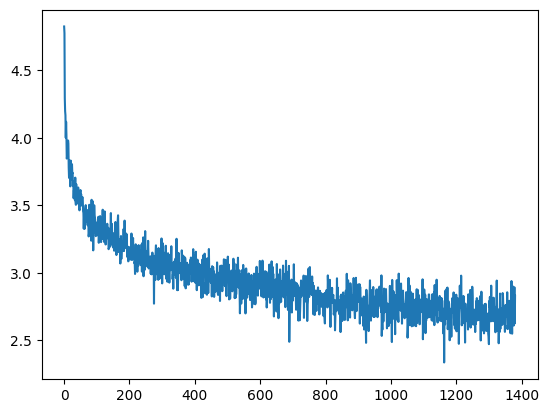

Computing metrics for n=100


  0%|          | 0/100 [00:00<?, ?it/s]

Train meteor: 0.1910, Train bleu: 0.0761
Valid meteor: 0.1990, Valid bleu: 0.0799
Valid spec-meteor: 0.0017, Valid spec-bleu: -0.0036


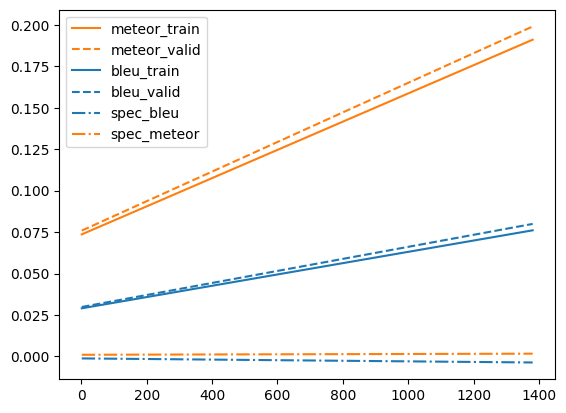

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

TRAIN TRUE: The tune features a melody played by bells with reverb and long overtones. A male voice with heavy 
processing sings low notes in a monotone melody. The sound appears to move from the right to the left side of the 
speakers. This song could be used for meditation purposes.

TRAIN PRED: The song is an instrumental. The song is medium tempo with a groovy bass line, steady drumming rhythm 
and keyboard accompaniment. The song is a groovy jazz song. The song audio quality is poor.

TEST TRUE: This is a Czech rap music piece. There is a male voice rapping in the Czech language. There is a 
medium-pitch synth playing the melody. The medium tempo electronic drum beat carries the rhythmic background. The 
atmosphere of the piece is loud and aggressive. This piece could be used in the soundtrack of a crime movie taking 
place in Central Europe.

TEST PRED: The low quality recording features a live performance of a folk song and it consists of passionate 
female vocal singing over punchy kick and snare hits, shimmering cymbals, groovy bass, shimmering hi hats and 
groovy piano melody. The recording is noisy and in mono.

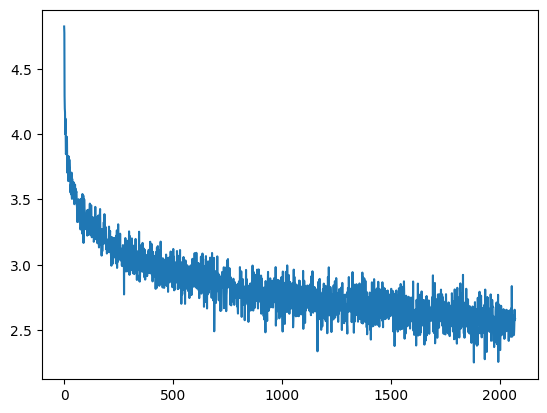

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

TRAIN TRUE: This audio contains someone playing a big acoustic drum set with a lot of fill-ins before breaking into
the next part of the song. It sounds as if it is the big finale. With loud hits on the cymbals a e-bass is playing 
a long note and the organ is playing loud chords in the higher register. This song may be playing live at a 
concert.

TRAIN PRED: The low quality recording features a live performance of a rock song and it consists of a passionate 
female vocal singing over punchy kick and snare hits, shimmering hi hats, punchy kick and shimmering hi hats. It 
sounds passionate and emotional.

TEST TRUE: This song is a low quality live recording of a performance. This features a male voice singing the main 
melody. At the end of the song, other voices sing with the main voice in harmony. This is accompanied by an 
electric guitar plucking chords. The double bass plays the root notes of the chords. The percussion plays the 
cymbal, increasing volume slowly, giving it a swell feel. The mood of the song seems romantic.

TEST PRED: The low quality recording features a cover of a rock song and it consists of passionate male vocal 
singing over punchy kick and snare hits, shimmering hi hats, punchy kick and shimmering hi hats. It sounds 
passionate, emotional and emotional - like something you would hear on the radio.

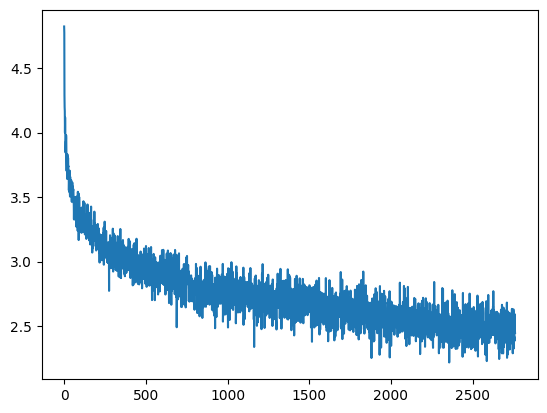

Computing metrics for n=100


  0%|          | 0/100 [00:00<?, ?it/s]

Train meteor: 0.1962, Train bleu: 0.0788
Valid meteor: 0.2153, Valid bleu: 0.0880
Valid spec-meteor: -0.0012, Valid spec-bleu: 0.0009


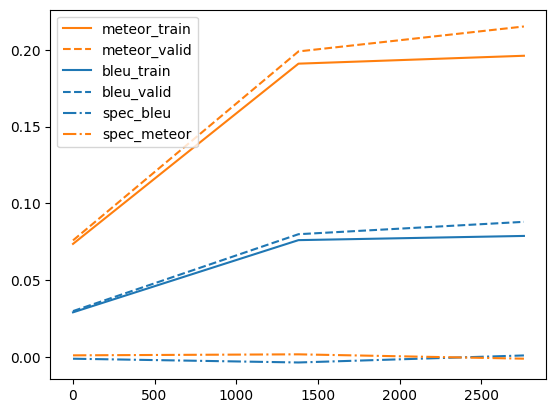

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

TRAIN TRUE: The harpsichord composition creates a sense of unease and apprehension through contrast between 
sustained cellos and the harpsichord's bright tones. Its haunting quality and dramatic flair evokes an emotional 
response.

TRAIN PRED: The low quality recording features a live performance of a rock song and it consists of passionate male
vocal singing over shimmering hi hats, punchy kick and snare hits, shimmering hi hats and groovy bass guitar. It 
sounds emotional and passionate.

TEST TRUE: There is an orchestra composed of the winds section and the timpani playing a dramatic tune with a 
rising melody. Afterwards, a thunder sound effect can be heard. Sounds from this piece can be sampled for use in 
advertisement jingles or in beat-making.

TEST PRED: The song is an instrumental. The song is medium tempo with a groovy bass line, steady drumming rhythm, 
keyboard accompaniment, steady drumming rhythm and a groovy bass line. The song is emotional and passionate. The 
audio quality is poor.

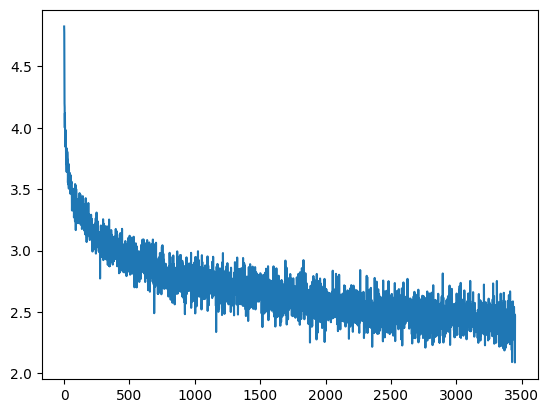

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

TRAIN TRUE: An instrumental children's song with a happy mood features an accordion playing chords, supported by 
percussion playing a simple beat and bass playing the root notes. The main melody is played on low frequencies by 
an instrument similar to the xylophone. There are no vocals in this track, making it suitable for use in children's
animation series.

TRAIN PRED: The track features a male vocalist singing melodically in a foreign language. The tempo is medium with 
a groovy bass line, keyboard accompaniment, steady drumming rhythm, and keyboard accompaniment. The song exudes 
passion and emotion. The song has poor audio quality.

TEST TRUE: Someone is hitting tibetan bowls that keep ringing out with a big release time. This may be playing in a
meditation workshop.

TEST PRED: The song is an instrumental. The song is medium tempo with a groovy bass line, steady drumming rhythm 
and keyboard accompaniment. The song is emotional and passionate. The song has poor audio quality.

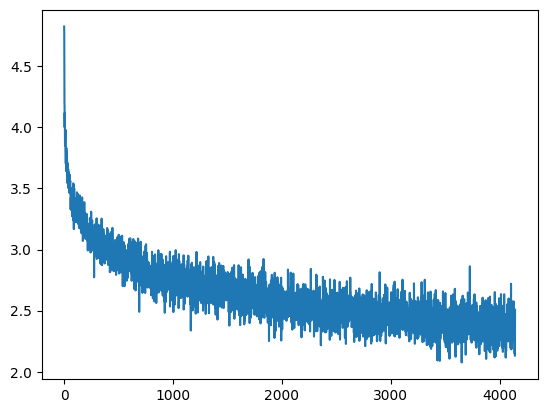

Computing metrics for n=100


  0%|          | 0/100 [00:00<?, ?it/s]

Train meteor: 0.2064, Train bleu: 0.0843
Valid meteor: 0.2059, Valid bleu: 0.0880
Valid spec-meteor: 0.0023, Valid spec-bleu: 0.0008


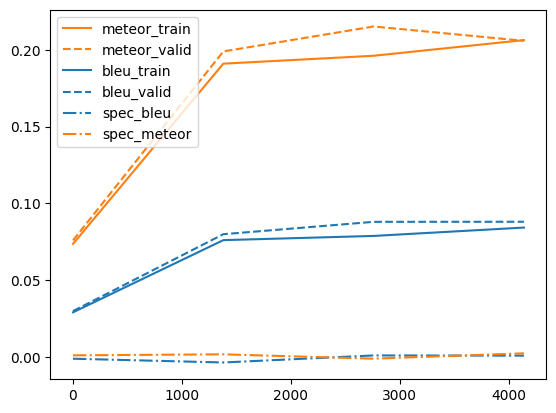

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

TRAIN TRUE: The low quality recording features a cover that consists of a muffled tuba melody. The recording is 
very noisy, in mono - as it was probably recorded with a phone, but it sounds happy and fun.

TRAIN PRED: The low quality recording features a live performance of a rock song and it consists of a passionate 
male vocal singing over groovy bass guitar, punchy kick and snare hits, shimmering hi hats, groovy electric guitar 
melody and groovy bass guitar. It sounds emotional, passionate and groovy.

TEST TRUE: The low quality recording features an afrobeats song played on speaker in a medium size room, and it 
consists at least syncopated rimshots, shimmering open hats, synth keys melody, groovy bass, repetitive male vocal 
melody and harmonizing vocals layered with it. Even though the recording is noisy, thin, messy and in mono, it 
still sounds groovy and like something you would want to dance to.

TEST PRED: The low quality recording features a live performance of a rock song that consists of flat male vocal 
singing over punchy kick and snare hits, shimmering hi hats and groovy bass guitar. The recording is noisy and in 
mono, as it was probably recorded with a poor quality microphone.

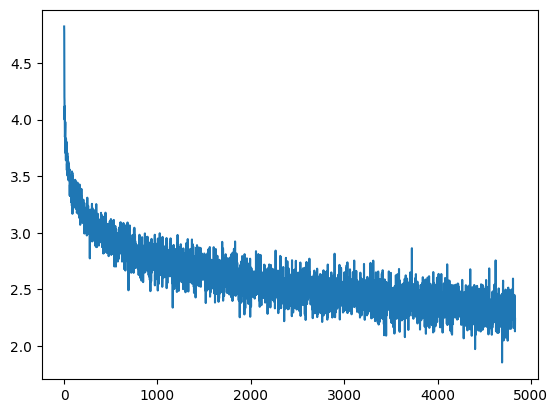

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

TRAIN TRUE: The song is an instrumental with a devilish voice laughing. The tempo is fast with a fast paced 
drumming rhythm with strong cymbal crashes. The song is probably an adult animated show designed to scare.

TRAIN PRED: The low quality recording features a cover of a rock song and it consists of a passionate male vocal 
singing over punchy kick and snare hits, shimmering hi hats, groovy bass and soft crash cymbals. It sounds 
emotional and passionate.

TEST TRUE: someone is strumming a melody on a banjo along with some chords. In the background you can hear people 
talking. This is an amateur recording. This song may be playing outside at a bonfire surrounded by friends and 
family.

TEST PRED: The song is an instrumental. The song is medium tempo with a groovy bass line, steady drumming rhythm, 
keyboard accompaniment and a groovy bass line. The song is exciting and energetic. The song has poor audio quality.

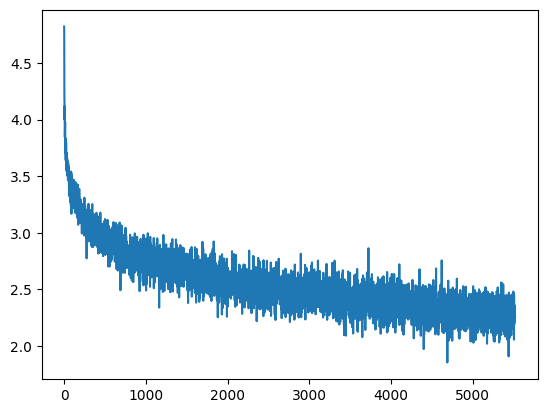

Computing metrics for n=100


  0%|          | 0/100 [00:00<?, ?it/s]

Train meteor: 0.1881, Train bleu: 0.0760
Valid meteor: 0.2288, Valid bleu: 0.0998
Valid spec-meteor: 0.0110, Valid spec-bleu: 0.0075


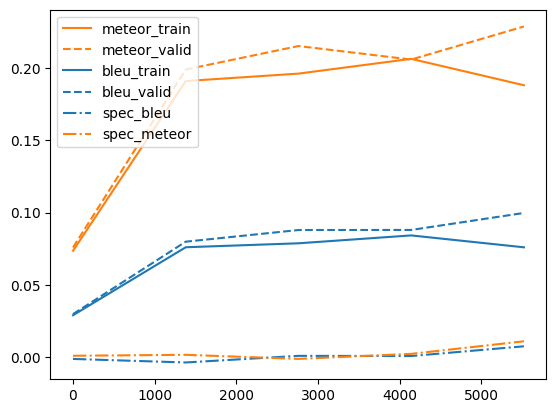

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

TRAIN TRUE: This slow rock song features a guitar playing arpeggiated chords. The guitar has added effects of 
chorus and reverb. The bass plays a descending run in the scale of the chords. The percussion plays the different 
cymbals one after the other. The recording quality is low. There are no voices in this song. This song can be 
played in a dreamy sequence of a movie.

TRAIN PRED: The low quality recording features a live performance of a folk song and it consists of harmonizing 
male vocals singing over acoustic rhythm guitar chords, groovy bass, shimmering hi hats and punchy kick and snare 
hits. It sounds groovy, energetic and exciting - like something you would hear in clubs.

TEST TRUE: The low quality recording features a flat male vocal singing over crowd cheering sound, punchy kick, 
shimmering cymbals, groovy accordion melody, acoustic rhythm guitar chords and smooth bass guitar. There is a short
toms roll before the bass drops. It sounds fun and happy.

TEST PRED: The low quality recording features a live performance of a rock song and it consists of passionate male 
vocal singing over groovy bass guitar, shimmering hi hats, punchy kick and snare hits, shimmering cymbals, groovy 
piano melody and groovy piano chords. It sounds energetic and exciting - like something you

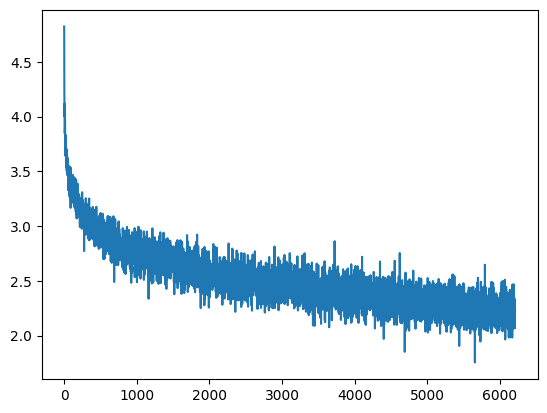

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

TRAIN TRUE: The recording is a casual sound check jam captured by amateurs. While the audio quality is low, the 
drums are most prominent. The bass guitar and acoustic drums overpower the almost inaudible male vocal. The piece 
has a relaxed vibe and could serve as a sample for beat production.

TRAIN PRED: The low quality recording features a live performance of a rock song and it consists of a passionate 
male vocal singing over punchy kick and snare hits, shimmering hi hats, groovy bass guitar, wide electric guitar 
melody and groovy piano melody. It sounds passionate, emotional and passionate.

TEST TRUE: A male vocalist sings this soft pop. The tempo is medium with an acoustic guitar accompaniment and sound
of static in the background. The song has simple lyrics and melody . It is informative and educational. This song 
is a Children’s  song/Alternative Pop.

TEST PRED: The low quality recording features a live performance of a folk song and it consists of passionate 
female vocal singing over acoustic rhythm guitar chords, groovy bass, shimmering shakers, punchy kick and snare 
hits, shimmering hi hats and soft crash cymbals. It sounds passionate and emotional.

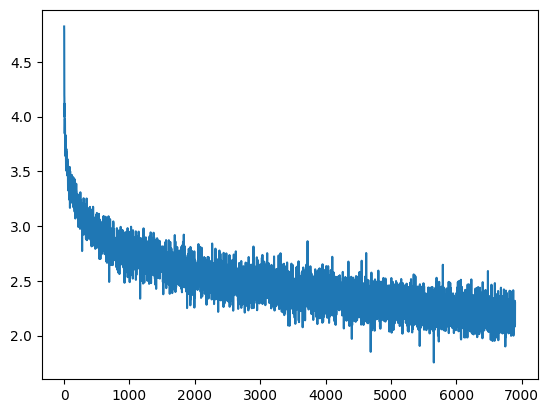

Computing metrics for n=100


  0%|          | 0/100 [00:00<?, ?it/s]

Train meteor: 0.2078, Train bleu: 0.0865
Valid meteor: 0.2246, Valid bleu: 0.1024
Valid spec-meteor: 0.0120, Valid spec-bleu: 0.0081


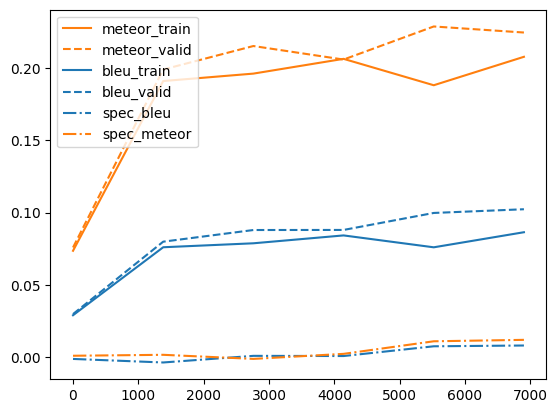

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

TRAIN TRUE: The song is an instrumental. The song is medium tempo with a percussionist practising Latin bass drums 
with a  drum stick to a music track with male vocals, trumpet harmony and other percussion. The audio quality is 
poor and boomy.

TRAIN PRED: The song is an instrumental. The song is medium tempo with a strong bass line, steady drumming rhythm, 
keyboard accompaniment and a percussive bass line. The song is exciting and energetic. The song is a retro pop hit 
with poor audio quality.

TEST TRUE: In this recording we hear two main instruments - the sitar and the tabla. The sitar player plays some 
simple and slow licks, in an emotive way. The tabla player plays a simple rhythm to support the sitar. The 
recording is an old recording - and this is a vintage south asian music piece.

TEST PRED: The low quality recording features a live performance of a folk song and it consists of a passionate 
male vocal singing over groovy piano melody, groovy bass, shimmering hi hats, punchy snare and soft kick hits. It 
sounds emotional, passionate and the recording is noisy and in mono.

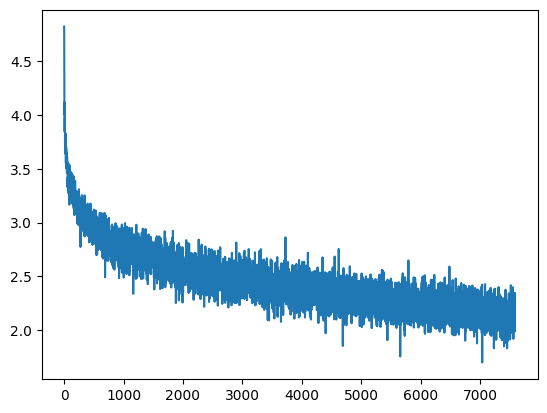

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

TRAIN TRUE: The song is an instrumental. The tempo is slow with an organ playing sustained chords. The audio 
quality is poor with a lot of hissing and strong gains that are distorted. The song is background music for a home 
video. The song is emotional and ominous.

TRAIN PRED: The low quality recording features a live performance of a folk song and it consists of harmonizing 
female vocals singing over groovy piano melody, shimmering hi hats, punchy snare and soft kick hits. It sounds 
energetic and groovy - like something you would hear in clubs.

TEST TRUE: A male singer sings this cheerful children’s song.  The song is medium tempo with reggae inspired 
drumming rhythm, guitar accompaniment, groovy bass line and keyboard harmony. The song is exciting and cheerful. 
The song is a children’s dance song.

TEST PRED: The song is an instrumental. The song is medium tempo with a groovy bass line, steady drumming rhythm, 
keyboard accompaniment and percussive bass line. The song is exciting and energetic. The song is a retro pop dance 
tune with poor audio quality.

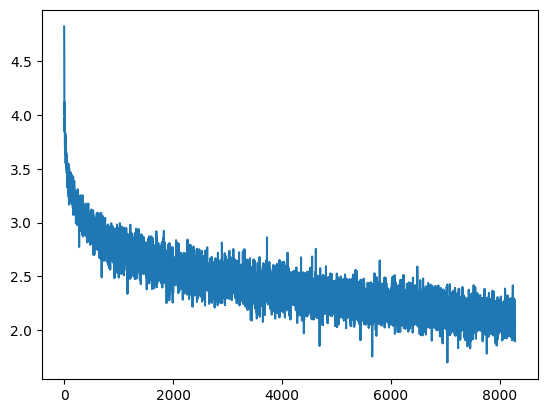

Computing metrics for n=100


  0%|          | 0/100 [00:00<?, ?it/s]

Train meteor: 0.2167, Train bleu: 0.0914
Valid meteor: 0.2241, Valid bleu: 0.0961
Valid spec-meteor: 0.0058, Valid spec-bleu: 0.0036


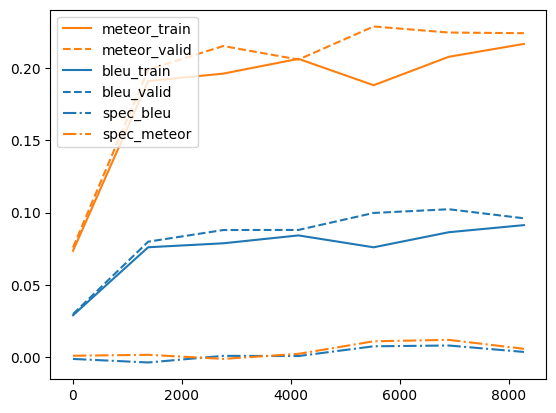

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

TRAIN TRUE: The drums in the house music track are minimalistic, featuring only a kick that plays a consistent four
on the floor pattern. The hi-hats provide a subtle contrast by playing on the off beats, while the bass part 
follows a syncopated dotted rhythm.

TRAIN PRED: The low quality recording features a live performance of a traditional song and it consists of a 
passionate male vocal singing over arpeggiated acoustic guitar melody and wooden percussive elements. The recording
is noisy and in mono.

TEST TRUE: The low quality recording features a man talking in the background over woodwind melody and wooden 
percussion. It sounds like a traditional folk song and the recording is noisy and in mono.

TEST PRED: The low quality recording features a live performance of a folk song and it consists of harmonizing male
vocals singing over groovy piano melody, groovy bass, shimmering hi hats, punchy snare and soft kick hits. It 
sounds passionate, groovy and groovy.

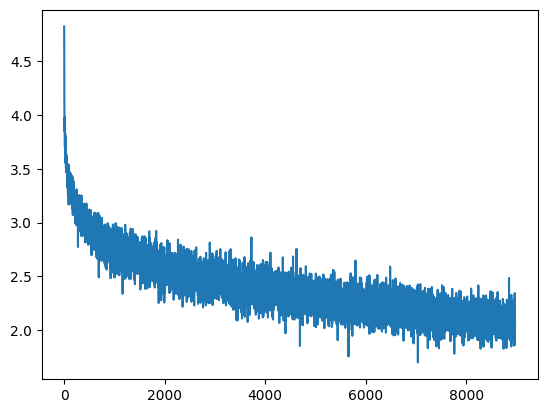

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

TRAIN TRUE: The composition lacks vocals and incorporates a moderate tempo. It features harmonious synthesizers, a 
consistent drum beat, and a groovy bass line. However, there is an unwelcome discordant element in the form of a 
gunshot-like sound that disrupts the overall harmony.

TRAIN PRED: The low quality recording features a cover of a rock song and it consists of passionate male vocal 
singing over groovy bass guitar, shimmering hi hats, punchy kick and snare hits, shimmering cymbals and groovy 
piano melody. It sounds emotional and passionate.

TEST TRUE: The low quality recording features a live performance of shoe tapping over a jazz song that consists of 
passionate female vocal singing over smooth bass and groovy key chords. There are crowd clapping sounds in the 
background. The actual sounds of shoe tappings is widely spread in the stereo image and it is reverberant, as it 
was probably performed in a huge space.

TEST PRED: This is a live performance of a rock music piece. There is a male vocalist singing melodically in the 
lead. The main tune is being played by the electric guitar while the bass guitar is playing in the background. The 
rhythmic background consists of a simple acoustic drum beat. The atmosphere is groovy. This

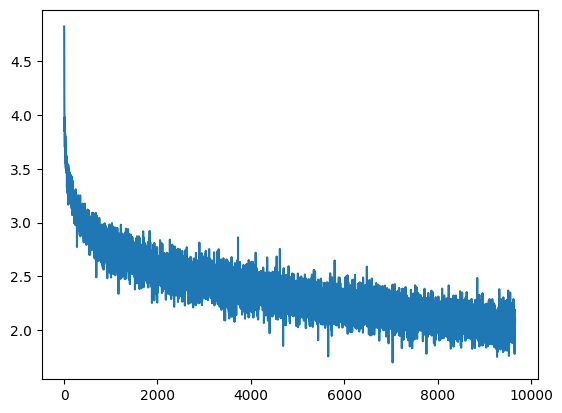

Computing metrics for n=100


  0%|          | 0/100 [00:00<?, ?it/s]

Train meteor: 0.1943, Train bleu: 0.0730
Valid meteor: 0.1938, Valid bleu: 0.0810
Valid spec-meteor: -0.0108, Valid spec-bleu: -0.0055


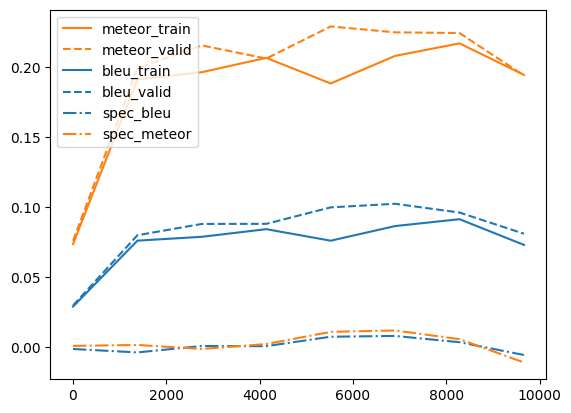

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

TRAIN TRUE: This song features a guitar being played. One guitar chord is struck per bar. This song lasts for 4 
bars and four chords are played. There are no voices in this song. There are no other instruments in this song.

TRAIN PRED: The low quality recording features a live performance of a folk song and it consists of a passionate 
male vocal singing over groovy bass guitar, shimmering hi hats, punchy snare and soft kick hits. It sounds 
passionate and easygoing.

TEST TRUE: A keyboard is playing chords with a string sound along with something that sounds like a cembalo or 
another keyboard playing chords and a melody in the mid to higher register. A male voice is singing in an upper key
sounding soulful and sensitive. This song may be playing for a sensual music video.

TEST PRED: The low quality recording features a live performance of a folk song and it consists of a passionate 
male vocal singing over groovy piano melody, groovy bass, shimmering hi hats, punchy snare and soft kick hits. It 
sounds happy, fun and happy - like something kids would listen to.

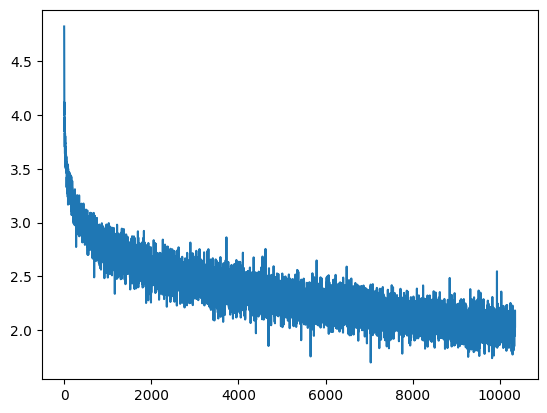

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

TRAIN TRUE: A male singer sings this Latin melody with backup singers in vocal harmony. The song is medium tempo 
with a brass band accompaniment, latin percussion and guitar accompaniment. The song is exciting and spirited. The 
song is perfect for Latin dancing. The song has a poor audio quality.

TRAIN PRED: The low quality recording features a live performance of a rock song and it consists of passionate male
vocal singing over groovy bass guitar, shimmering hi hats, punchy snare and soft kick hits. There are some crowd 
chattering noises in the background. It sounds energetic and addictive - like something you would hear in clubs

TEST TRUE: This song contains a evolving synth pad sound in the higher register with noise. A piano is playing a 
sad minor chord progression in the mid range. Then a strong industrial sounding digital drum comes. This song may 
be playing in a very sad movie scene.

TEST PRED: The low quality recording features a live performance of a traditional song and it consists of a 
passionate male vocal singing over wooden percussive elements. The recording is noisy and in mono.

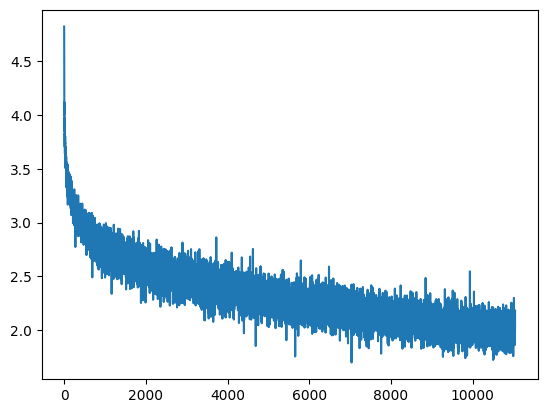

Computing metrics for n=100


  0%|          | 0/100 [00:00<?, ?it/s]

Train meteor: 0.1929, Train bleu: 0.0832
Valid meteor: 0.2140, Valid bleu: 0.0939
Valid spec-meteor: 0.0086, Valid spec-bleu: 0.0078


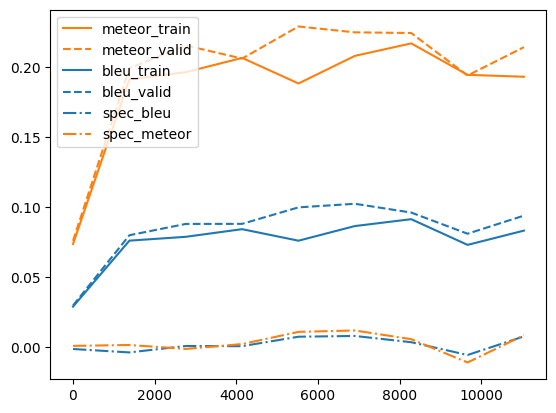

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

TRAIN TRUE: The Soca track is captured in a low quality recording. It comprises a repetitive male vocal singing 
accompanied by wide background grunts. The track is characterized by a punchy kick, syncopated snare, wooden 
percussion, and repetitive buzzy synth. Overall, it has an energetic and uptempo vibe.

TRAIN PRED: The song is an instrumental. The song is medium tempo with a harpsichord playing percussively with no 
other instrumentation. The song is emotional and passionate. The song audio quality is poor.

TEST TRUE: The low quality recording features a live performance of a traditional song and it consists of 
passionate male vocal, alongside passionate background male vocal singing over sustained accordion melody and some 
tinny percussive elements. Even though it is a bit distorted, mono and noisy, it still sounds soulful.

TEST PRED: The low quality recording features a cover of a rock song and it consists of harmonizing male vocals 
singing over acoustic rhythm guitar. The recording is noisy and in mono, as it was probably recorded with a phone, 
but it sounds passionate and emotional.

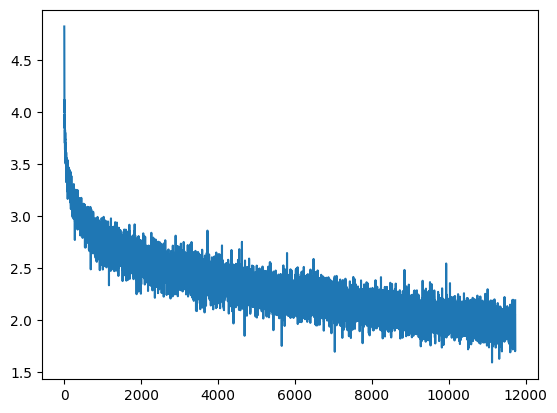

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

TRAIN TRUE: The song is an instrumental tolled by a guitarist introducing the lesson. The tempo is slow, a guitar 
playing gently with feedback buzz noise. The song is relaxing but has poor audio quality with a feedback noise.

TRAIN PRED: The low quality recording features a cover of a rock song and it consists of a passionate male vocal 
singing over acoustic rhythm guitar. The recording is noisy and in mono, as it was probably recorded with a phone.

TEST TRUE: Someone is playing various singing bowls. From low sounding ones to high sounding ones creating a 
melody. This song may be playing in a meditation session.

TEST PRED: The song is an instrumental. The song is medium tempo with a groovy bass line, steady drumming rhythm, 
keyboard accompaniment and a percussive bass line. The song is exciting and energetic. The song is a techno dance 
tune with poor audio quality.

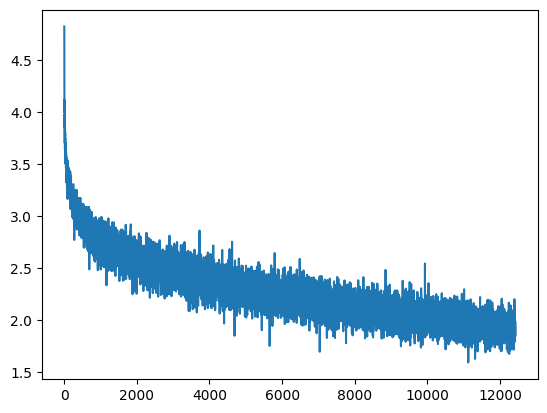

Computing metrics for n=100


  0%|          | 0/100 [00:00<?, ?it/s]

Train meteor: 0.2033, Train bleu: 0.0778
Valid meteor: 0.2265, Valid bleu: 0.0990
Valid spec-meteor: 0.0055, Valid spec-bleu: 0.0017


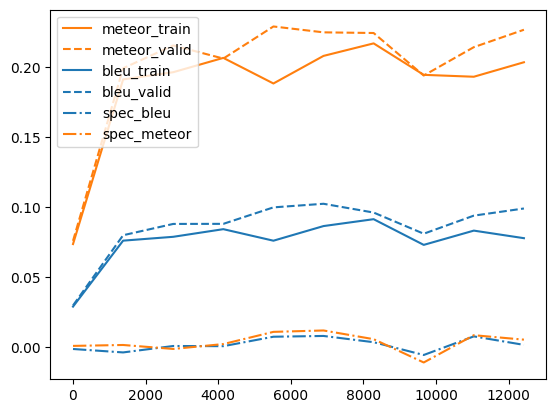

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

TRAIN TRUE: The low quality recording features a pop song that consists of groovy piano chords, harmonizing 
background vocals, punchy kick and snare hits, shimmering shakers, groovy bass and muffled female vocals singing 
over it. It sounds energetic, happy, fun and addictive - like something you would hear on a radio.

TRAIN PRED: The low quality recording features a live performance of a rock song and it consists of flat male vocal
singing over groovy bass guitar, shimmering hi hats, punchy snare and soft kick hits. It sounds groovy, funky and 
addictive - thanks to that cadence.

TEST TRUE: This is a thrilling orchestral piece that feels epic, suspenseful and intense. There are string 
instruments like violins and cellos, and timpani for percussion. There is one over-bearing vibrational sound that 
overwhelms the whole arrangement - it is played once and rings for three seconds.

TEST PRED: The low quality recording features a live performance of a rock song and it consists of a passionate 
male vocal singing over groovy bass guitar, shimmering hi hats, punchy snare and soft kick hits. It sounds 
emotional and passionate.

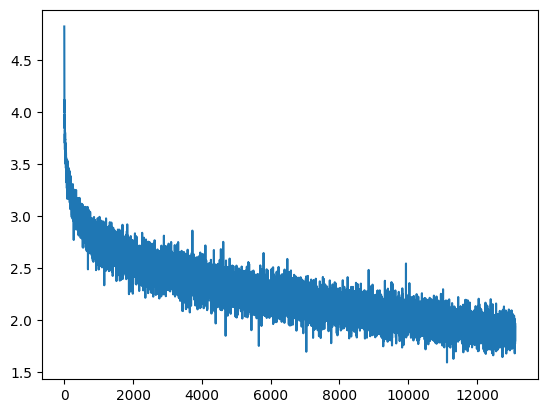

  0%|          | 0/138 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

TRAIN TRUE: This instrumental track features a medium tempo and incorporates a melodious keyboard harmony, rhythmic
guitar accompaniment, punchy drumming, subtle bass line, synth arrangement, and tambourine beats. The overall sound
is soft, mellow, ambient, pleasant, uplifting, and mellifluous.

TRAIN PRED: The low quality recording features a live performance of a rock song and it consists of harmonizing 
male vocals singing over groovy bass guitar, shimmering cymbals, punchy kick and snare hits, shimmering cymbals and
mellow synth keys melody. It sounds emotional and passionate.

TEST TRUE: The low quality recording features a traditional song that consists of a flat male vocal, alongside 
monotone female vocal, singing over sustained strings melody, wooden percussion, shimmering shakers and some claps.
It sounds passionate and the recording is in mono and noisy.

TEST PRED: The low quality recording features a live performance of a rock song and it consists of harmonizing male
vocals singing over groovy bass guitar, shimmering hi hats, punchy snare and soft kick hits. There are some crowd 
chattering noises in the background. It sounds passionate and emotional.

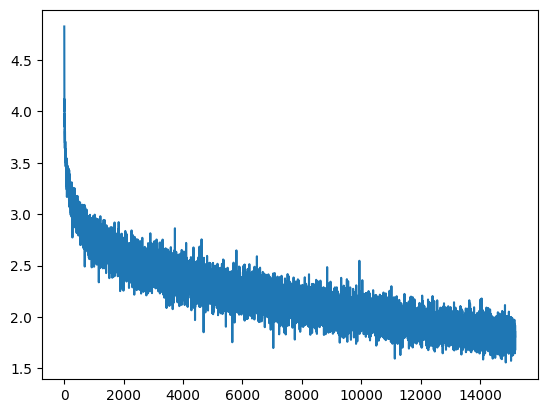

Computing metrics for n=100


  0%|          | 0/100 [00:00<?, ?it/s]

Train meteor: 0.2109, Train bleu: 0.0902
Valid meteor: 0.1956, Valid bleu: 0.0795
Valid spec-meteor: 0.0092, Valid spec-bleu: 0.0025


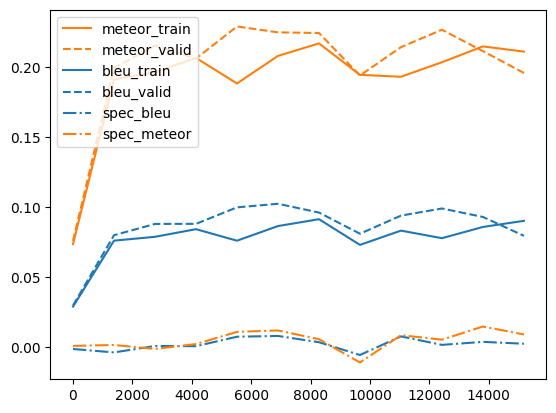

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

In [ ]:
for epoch in tqdm(range(epoch, num_epochs)):
    wlog(f"\nEpoch {epoch}")

    torch.save({
        "model": model.state_dict(), 
        "b2t": b2t.state_dict(), 
        "opt": opt
    }, checkpoint_dir / f"chkp_{string_info}.pt")
    #}, checkpoint_dir / f"chkp_{epoch}.pt")
    
    if epoch>150 and epoch % 20 == 0:
        print("Checkpoint saved")
        wlog("Checkpoint saved")
        torch.save({
            "model": model.state_dict(), 
            "b2t": b2t.state_dict(), 
            "opt": opt
        }, checkpoint_dir / f"chkp_{string_info}_e{epoch}.pt")

    if epoch == gpt2_finetune_start_epoch:
        print("Started finetuning b2t")
        wlog("Started finetuning b2t")
        torch.save({
        "model": model.state_dict(), 
        "b2t": b2t.state_dict(), 
        "opt": opt
        }, checkpoint_dir / f"chkp_{string_info}.pt")
        opt.param_groups[0]["lr"] = b2t_lr
        for pg in opt.param_groups[1:]:
            pg["lr"] = gpt2_finetune_lr

    for step, (caption_batch, embedding_batch) in enumerate(tqdm(train_dataloader)):
        # tokenize and prepare inputs for forward
        input_ids, input_ids_target = tokenize(list(caption_batch))
        inputs_embeds, input_ids_target = transform_input_ids(
            embedding_batch, input_ids, input_ids_target
        )

        apply_grad_cond = step % gradient_acc_fact == 0
        losses.append(
            update_step(inputs_embeds, input_ids_target, apply_grad=apply_grad_cond)
        )

        if epoch % 5 == 0 and step % 500 == 0:
            wlog(f"Loss {np.mean(losses[-500:])}\n")
            eval_step(string_info=string_info)
                
            plt.plot(losses, label='train_loss')
            plt.savefig(f"plots/plot_loss_{string_info}.png")
            plt.show()
            plt.clf()
            
            if epoch % 10 == 0:
            
                metrics_results = metrics_step(n=100)
                metrics['step'].append(len(losses))
                for m in ['meteor_train', 'meteor_valid', 'bleu_train', 'bleu_valid', 'spec_bleu', 'spec_meteor']:
                    metrics[m].append(metrics_results[m])
                    plt.plot(metrics['step'], metrics[m], label=m, linestyle=m_styles[m][1], color=m_styles[m][0])
                plt.legend()
                plt.savefig(f"plots/plot_metrics_{string_info}.png")
                plt.show()

                with open(f'outputs/train_metrics_{string_info}.npy', 'wb') as f:
                    metrics_to_save = {k: np.array(a) for k, a in metrics.items()}
                    metrics_to_save['loss'] = np.array(losses)
                    np.save(f, metrics_to_save)

# Generate eval captions

In [18]:
import evaluate

meteor = evaluate.load('meteor')
google_bleu = evaluate.load('google_bleu')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [25]:
eval_true_captions = []
eval_pred_captions = []

for ep in tqdm(["240", "245", "250", "255"]):
    # load epoch checkpoint
    model_path = f"checkpoints/chkp_no_0.0001_0_0.0001_e{ep}.pt"
    data_dict = torch.load(model_path)
    model.load_state_dict(data_dict['model'])
    b2t.load_state_dict(data_dict['b2t'])

    eval_test_dataloader = DataLoader(test_data, 1, shuffle=False)

    # generate a bunch of captions with this checkpoint
    # for some reason hf generate() breaks atm when using batched captions, idk why
    for i, (caption_batch, embedding_batch) in enumerate(tqdm(eval_test_dataloader)):
        pred = eval(list(caption_batch), embedding_batch, **generation_params)
        eval_true_captions.append(caption_batch[0])
        eval_pred_captions.append(pred[0])
        if i >= 1000:
            break

    gleu_score = google_bleu.compute(predictions=eval_pred_captions, references=eval_true_captions)['google_bleu']
    meteor_score = meteor.compute(predictions=eval_pred_captions, references=eval_true_captions)['meteor']
    print(ep, gleu_score, meteor_score)
    
    eval_true_shuffled = sorted(eval_true_captions, key=lambda k: random.random())

    shuffled_gleu_score = google_bleu.compute(predictions=eval_pred_captions, references=eval_true_shuffled)['google_bleu']
    shuffled_meteor_score = meteor.compute(predictions=eval_pred_captions, references=eval_true_shuffled)['meteor']
    print(ep, gleu_score-shuffled_gleu_score, meteor_score-shuffled_meteor_score)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

240 0.09176385070004109 0.21041236368091049
240 0.013262491707257809 0.02459959648551288


  0%|          | 0/550 [00:00<?, ?it/s]

245 0.09164398088063055 0.21363346802230665
245 0.01235321176950216 0.024470595294925124


  0%|          | 0/550 [00:00<?, ?it/s]

250 0.0916267564865007 0.2151841683066235
250 0.014104659248265997 0.02897780008661796


  0%|          | 0/550 [00:00<?, ?it/s]

255 0.09191405725832551 0.21574687256667727
255 0.013624711813703463 0.029421440448513164


In [26]:
eval_true_captions = []
eval_pred_captions = []

for ep in tqdm(["260", "270", "275", "280"]):
    # load epoch checkpoint
    model_path = f"checkpoints/chkp_no_0.0001_0_0.0001_e{ep}.pt"
    data_dict = torch.load(model_path)
    model.load_state_dict(data_dict['model'])
    b2t.load_state_dict(data_dict['b2t'])

    eval_test_dataloader = DataLoader(test_data, 1, shuffle=False)

    # generate a bunch of captions with this checkpoint
    # for some reason hf generate() breaks atm when using batched captions, idk why
    for i, (caption_batch, embedding_batch) in enumerate(tqdm(eval_test_dataloader)):
        pred = eval(list(caption_batch), embedding_batch, **generation_params)
        eval_true_captions.append(caption_batch[0])
        eval_pred_captions.append(pred[0])
        if i >= 1000:
            break

    gleu_score = google_bleu.compute(predictions=eval_pred_captions, references=eval_true_captions)['google_bleu']
    meteor_score = meteor.compute(predictions=eval_pred_captions, references=eval_true_captions)['meteor']
    print(ep, gleu_score, meteor_score)
    
    eval_true_shuffled = sorted(eval_true_captions, key=lambda k: random.random())

    shuffled_gleu_score = google_bleu.compute(predictions=eval_pred_captions, references=eval_true_shuffled)['google_bleu']
    shuffled_meteor_score = meteor.compute(predictions=eval_pred_captions, references=eval_true_shuffled)['meteor']
    print(ep, gleu_score-shuffled_gleu_score, meteor_score-shuffled_meteor_score)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/550 [00:00<?, ?it/s]

260 0.09301781424515645 0.21948975562326373
260 0.012793587918638452 0.026416504783445094


  0%|          | 0/550 [00:00<?, ?it/s]

270 0.09167655415742967 0.21664909750262723
270 0.01294979324549847 0.028667107157780647


  0%|          | 0/550 [00:00<?, ?it/s]

275 0.09089179808423928 0.21627594449332305
275 0.01227726257075086 0.026467379028567106


  0%|          | 0/550 [00:00<?, ?it/s]

280 0.09235137201067033 0.2190253816800136
280 0.013874978322179321 0.03065359068924778


In [ ]:
json.dump(dict(
    eval_true_captions=eval_true_captions,
    eval_pred_captions=eval_pred_captions
), open('preds.json', 'w'))

In [ ]:
gleu_score = google_bleu.compute(predictions=eval_pred_captions, references=eval_true_captions)['google_bleu']
meteor_score = meteor.compute(predictions=eval_pred_captions, references=eval_true_captions)['meteor']

gleu_score, meteor_score

In [ ]:
eval_true_shuffled = sorted(eval_true_captions, key=lambda k: random.random())

gleu_score = google_bleu.compute(predictions=eval_pred_captions, references=eval_true_shuffled)['google_bleu']
meteor_score = meteor.compute(predictions=eval_pred_captions, references=eval_true_shuffled)['meteor']
    
gleu_score, meteor_score

In [ ]:
json.dump(dict(
    eval_true_captions=eval_true_captions,
    eval_pred_captions=eval_pred_captions
), open('preds.json', 'w'))